In [1]:
%load_ext autoreload
%autoreload 2

import dolfin
import numpy
import sympy
from numpy import linspace
from sympy import lambdify
import scipy.optimize
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import dolfin_mech     as dmech
import matplotlib.pyplot as plt
import micro_poro_structure_generator as gen
from shapely.geometry import LineString

## Experimental data

In [2]:
smith_gamma_0_inf = numpy.array([
[0.10261460510291531, 10.12867762052346],
[1.0670404781958325, 14.37579169470247],
[1.8163827631860017, 17.871672403295065],
[1.9748719391855454, 19.573866563700566],
[2.1594615644511066, 22.10912106780112],
[2.5164854274353257, 27.42241317661467],
[2.9066567368768337, 34.04958685994136],
[3.3937484592561367, 43.15381056445911],
[3.9145957698017324, 52.5539186331707],
[4.541473207864893, 60.481952639401214],
[5.217917918528443, 68.62351762513866],
[6.241172193676007, 77.1946779015478],
[7.261758091937126, 83.31499516204023],
[8.569970196446437, 88.40221757910093],
[9.93786458361406, 92.1302691779124],
[11.647661204005693, 95.2594309371248],
[13.021679205851322, 96.96864019630578],
[14.650664963066118, 98.82977258733175],
[16.227410106371963, 100.22737839699602]])

p_smith_gamma_0_inf = smith_gamma_0_inf[:, 0]
v_smith_gamma_0_inf = smith_gamma_0_inf[:, 1]


smith_gamma_0_inf_reduced = numpy.array([
[0.10261460510291531, 10.12867762052346],
[1.8163827631860017, 17.871672403295065],
[3.3937484592561367, 43.15381056445911],
[5.217917918528443, 68.62351762513866],
[7.261758091937126, 83.31499516204023],
[8.569970196446437, 88.40221757910093],
[9.93786458361406, 92.1302691779124],
[11.647661204005693, 95.2594309371248],
[13.021679205851322, 96.96864019630578],
[14.650664963066118, 98.82977258733175],
[16.227410106371963, 100.22737839699602]])




smith_gamma_0_def = numpy.array([
[0.005402644675070236, 9.624888713050963],
[0.1668047591213219, 13.336914018852813],
[0.4784246543693627, 17.576913749523595],
[0.7895795886163685, 22.629626469396946],
[1.049528165662428, 26.98978789511438],
[1.4526998927990538, 32.2156737299415],
[1.807379219882079, 37.46576576043189],
[2.0644723299109122, 42.66182849231477],
[2.3007533812195033, 46.81773063897312],
[2.509263120564099, 50.627115670978604],
[2.7535495873687714, 53.840855918968124],
[3.033910963145054, 58.58295961002058],
[3.3518634250702353, 62.883333664190346],
[3.6492919019388586, 66.62339892776788],
[3.9266765165237323, 69.96982003584168],
[4.321256572989058, 74.121866131073],
[4.807696750702351, 77.78184588726738],
[5.332289000120139, 81.33215478582349],
[6.19081927283565, 85.6636911592568],
[7.169511640775174, 89.30143732413063],
[8.129095122356942, 92.16244173869191],
[9.204640888381636, 94.35632139473529],
[10.399191401051679, 96.39406440195621],
[11.51269213574782, 97.66598370813628],
[12.540963497384666, 98.63105344989252],
[13.656157296595447, 99.30917055539747],
[14.80094434734493, 99.84170685998932],
[16.163451913791032, 100.36715330509323]])

p_smith_gamma_0_def = smith_gamma_0_def[:, 0]
v_smith_gamma_0_def = smith_gamma_0_def[:, 1]



exp_gamma_inflation = numpy.array([
[0.06730815882374686, 9.704082647849843],
[1.9322465182796098, 18.75700665185124],
[3.4904268573026025, 25.24833117463643],
[5.0286694664442555, 31.078643783434696],
[6.485063777631968, 36.02635154219419],
[8.137474528223422, 40.85147550038641],
[9.557268322351398, 44.93923178251944],
[10.429459351434275, 48.12334953139618],
[11.13903532432907, 50.721496058796426],
[11.582845653740943, 53.03754902052973],
[12.014764100158954, 56.587605306853625],
[12.381906403639288, 59.541154955663416],
[12.738693216998744, 63.12519130210577],
[13.224845321048353, 67.58970758392769],
[13.71729461430763, 72.15341503063678],
[14.467392949227415, 77.39116992549216],
[15.062808361558297, 80.80264982801819],
[15.7830582217812, 83.76429049803036],
[16.604808563137663, 86.56123913729672],
[17.30965659020128, 88.45492630421222],
[18.262457705876646, 90.70552669360191],
[19.188369419312806, 92.41092859026006],
[20.0090963410746, 93.80091253847083],
[21.134686061797648, 95.50390718915142],
[22.37148737847479, 97.0422116665291],
[23.392364849410395, 98.10527452251237],
[24.66582227631044, 99.1742013256802],
[25.503449519675073, 99.89714224285996],
[26.342977038435237, 100.47381510525955]])

p_exp_gamma_inflation = exp_gamma_inflation[:, 0]
v_exp_gamma_inflation = exp_gamma_inflation[:, 1]

exp_gamma_deflation = numpy.array([
[0.033315466508945735, 10.125150090091784],
[0.3325077628271477, 15.469867690860674],
[0.6191410581934792, 20.2188364908121],
[0.9880522350473163, 25.69086322684497],
[1.41976347058443, 30.849494769731063],
[1.903019676225418, 36.29383074725043],
[2.387852706130785, 40.9955684895495],
[2.8946399815632855, 45.92731709905034],
[3.389100736544433, 50.388452834823525],
[3.8509485204421114, 54.5232692898636],
[4.435283204568979, 58.93423177845629],
[4.978297006690818, 63.01316892177646],
[5.6483816180411806, 66.71826968050705],
[6.308889043555006, 70.19024649776242],
[7.141245044266598, 73.81700403053497],
[8.12620933179617, 77.12116088322801],
[9.284250298037113, 79.99941722729517],
[10.286397926909286, 81.87430521478251],
[11.52414432736027, 83.52747024521612],
[12.420447627485954, 84.82535660291342],
[13.238940714873207, 86.536784044287],
[14.338735207886664, 88.75594535542344],
[15.472133241072749, 90.83806081569836],
[16.52893905718616, 92.9106327344357],
[17.75050784715548, 94.83745482495748],
[18.961812117634558, 96.40332561217544],
[20.212168058276653, 97.9201803391296],
[21.564067438405665, 98.71853529483946],
[23.081649606544804, 99.45258743535082],
[24.763893670061364, 100.17813063001095],
[26.29242769134445, 100.41890352128218]])

p_exp_gamma_deflation = exp_gamma_deflation[:, 0]
v_exp_gamma_deflation = exp_gamma_deflation[:, 1]


## Defining geometry

In [3]:
seeds_filename = "Geometries/Hexagon/ch4.dat"
mesh_filebasename = "Geometries/Hexagon/ch4-mesh"

domain_y = 0.1 * 0.8
domain_x = domain_y * numpy.sqrt(3)/1.5/2
thickness = 0.012 * 0.8

gen.generate_seeds_semi_regular(
    DoI = 0.,
    row = 1,
    domain_y = domain_y,
    seeds_filename = seeds_filename)
gen.generate_mesh_2D_rectangle_w_voronoi_inclusions(
    mesh_filename = mesh_filebasename,
    seeds_filename = seeds_filename,
    h = thickness,
    lcar = thickness/5,
    domain_x = domain_x,
    domain_y = domain_y,
    shift_y = 0.,
    remove_seeds = True)

mesh = dolfin.Mesh()
dolfin.XDMFFile(mesh_filebasename+".xdmf").read(mesh)
dV = dolfin.Measure("dx",domain=mesh)

coord = mesh.coordinates()
xmax = max(coord[:,0]); xmin = min(coord[:,0])
ymax = max(coord[:,1]); ymin = min(coord[:,1])

V = (xmax - xmin)*(ymax - ymin)
VS0 = dolfin.assemble(dolfin.Constant(1) * dV)
Vf0 = V - VS0

[[0.02309401 0.02      ]
 [0.         0.06      ]
 [0.06928203 0.02      ]
 [0.04618802 0.06      ]]
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 122 (Line)
Info    : [ 10%] Meshing curve 123 (Line)
Info    : [ 10%] Meshing curve 124 (Line)
Info    : [ 20%] Meshing curve 152 (Line)
Info    : [ 20%] Meshing curve 153 (Line)
Info    : [ 20%] Meshing curve 154 (Line)
Info    : [ 30%] Meshing curve 155 (Line)
Info    : [ 30%] Meshing curve 156 (Line)
Info    : [ 30%] Meshing curve 157 (Line)
Info    : [ 40%] Meshing curve 158 (Line)
Info    : [ 40%] Meshing curve 159 (Line)
Info    : [ 40%] Meshing curve 160 (Line)
Info    : [ 50%] Meshing curve 161 (Line)
Info    : [ 50%] Meshing curve 162 (Line)
Info    : [ 50%] Meshing curve 163 (Line)
Info    : [ 60%] Meshing curve 164 (Line)
Info    : [ 60%] Meshing curve 165 (Line)
Info    : [ 70%] Meshing curve 166 (Line)
Info    : [ 70%] Meshing curve 

/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  m = (Q[1] - P[1])/(Q[0] - P[0])
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:61: RuntimeWarning: invalid value encountered in double_scalars
  x = (c2 - c1)/(m1 - m2)
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:62: RuntimeWarning: invalid value encountered in double_scalars
  y = (m2*c1 - m1*c2)/(m2 - m1)
/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/micro_poro_structure_generator/generate_mesh_2D_rectangle_w_voronoi_inclusions.py:45: RuntimeWarning: invalid value encountered in double_scalars
  c = P[1] - m * P[0]


Info    : Running '/Users/tayebi/miniconda3/envs/all/bin/gmsh -2 -o Geometries/Hexagon/ch4-mesh.msh -format msh22 Geometries/Hexagon/ch4-mesh.msh' [Gmsh 4.9.0, 1 node, max. 1 thread]
Info    : Started on Mon Mar  4 14:35:59 2024
Info    : Reading 'Geometries/Hexagon/ch4-mesh.msh'...
Info    : 63 entities
Info    : 591 nodes
Info    : 964 elements
Info    : Done reading 'Geometries/Hexagon/ch4-mesh.msh'
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 0.000128224s, CPU 4.8e-05s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 4.8413e-05s, CPU 2.4e-05s)
Info    : 603 nodes 998 elements
Info    : Writing 'Geometries/Hexagon/ch4-mesh.msh'...
Info    : Done writing 'Geometries/Hexagon/ch4-mesh.msh'
Info    : Stopped on Mon Mar  4 14:35:59 2024 (From start: Wall 0.00962221s, CPU 0.289102s)
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 591 vertices
Found all vertices
Expecting 964 cells
Found all cells
Conversion done
Phis0=0.3724921938165302
Phif0=0.

In [4]:
mesh = dolfin.Mesh()
dolfin.XDMFFile(mesh_filebasename+".xdmf").read(mesh)
dV = dolfin.Measure("dx",domain=mesh)

coord = mesh.coordinates()
xmax = max(coord[:,0]); xmin = min(coord[:,0])
ymax = max(coord[:,1]); ymin = min(coord[:,1])

V = (xmax - xmin)*(ymax - ymin)
VS0 = dolfin.assemble(dolfin.Constant(1) * dV)
Vf0 = V - VS0

## Loading 

In [5]:
qois_filename = "Fig5-qois.dat"
res_basename = "Fig5"

load_params = {}
load_params["pf"] = 4
load_params["sigma_bar_00"] = 0.0
load_params["sigma_bar_11"] = 0.0
load_params["sigma_bar_01"] = 0.0
load_params["sigma_bar_10"] = 0.0

In [6]:
params_id_simth = [0.09434801341294823, 0.016887557819879336, 0.6194667445820958, 3.166746717075454]

In [7]:

params = params_id_simth
mat_params = {"model":"exponential", "parameters":{"beta1":params[0], "beta2":params[1], "beta3":params[2], "alpha":params[3]}}

load_params = {}
load_params["pf"] = 3
load_params["sigma_bar_00"] = 0.0
load_params["sigma_bar_11"] = 0.0
load_params["sigma_bar_01"] = 0.0
load_params["sigma_bar_10"] = 0.0

phi = dmech.run_HollowBox_MicroPoroHyperelasticity(
    dim=2,
    mesh=mesh,
    mat_params=mat_params,
    load_params=load_params,
    step_params={"Deltat":1., "dt_ini":0.1, "dt_min":0.005, "dt_max":0.1},
    res_basename=res_basename,
    write_qois_limited_precision=False,
    verbose=1
)

qois_vals = numpy.loadtxt(qois_filename)
qois_name_list = open(qois_filename).readline().split()
pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]

for i in range(1, len(vf_lst)):
    slope = (vf_lst[i] - vf_lst[i - 1])/(pf_lst[i] - pf_lst[i - 1])
    if slope < 0.1 * Vf0:
        break

vf_asym = vf_lst[i]
vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]
S_lst = qois_vals[:, qois_name_list.index("S_area") - 1]
S_hat_gamma_0_lst = [S/S_lst[0] for S in S_lst]

vf_gamma_0_lst = vf_lst
pf_gamma_0_lst = pf_lst


def loading_model(gamma, p_ini):
    gamma = gamma * 1e-3
    load_params = {}
    load_params["pf_lst"] = [p_ini, 3]
    load_params["sigma_bar_00_lst"] = [0.0, 0.0]
    load_params["sigma_bar_11_lst"] = [0.0, 0.0]
    load_params["sigma_bar_01_lst"] = [0.0, 0.0]
    load_params["sigma_bar_10_lst"] = [0.0, 0.0]
    load_params["gamma_lst"] = [gamma, gamma]

    step_params = {}
    step_params["n_steps"] = 2
    step_params["Deltat"] = 1.
    step_params["dt_ini"] = 0.01
    step_params["dt_min"] = 0.0005
    step_params["dt_max"] = 0.005

    dmech.run_HollowBox_MicroPoroHyperelasticity(
        dim=2,
        mesh=mesh,
        mat_params=mat_params,
        load_params=load_params,
        step_params=step_params,
        res_basename=res_basename,
        write_qois_limited_precision=False,
        verbose=1
    )

    qois_vals = numpy.loadtxt(qois_filename)
    qois_name_list = open(qois_filename).readline().split()

    
    pf_lst = qois_vals[:, qois_name_list.index("p_f") - 1]*10.20
    vf_lst = qois_vals[:, qois_name_list.index("vf") - 1]
    vf_lst = [vf_/vf_asym *100 for vf_ in vf_lst]
    S_lst = qois_vals[:, qois_name_list.index("S_area") - 1]
    S_hat_lst = [S/S_lst[0] for S in S_lst]

    index = numpy.argmin(numpy.abs(pf_lst - p_ini*10.20), axis=None)

    return pf_lst[index:], vf_lst[index:], S_hat_lst[index:]

/Users/tayebi/miniconda3/envs/all/lib/python3.8/site-packages/ufl/exproperators.py:336: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


In [8]:
model_response_lst = []
model_response_lst.append([0, loading_model(0, 0.)])
model_response_lst.append([3, loading_model(3, 0.1)])
model_response_lst.append([5, loading_model(5, 0.1)])
model_response_lst.append([7, loading_model(7, 0.3)])
model_response_lst.append([10, loading_model(10, 0.3)])
model_response_lst.append([28, loading_model(28, 1.6)])
model_response_lst.append([30, loading_model(30, 1.8)])

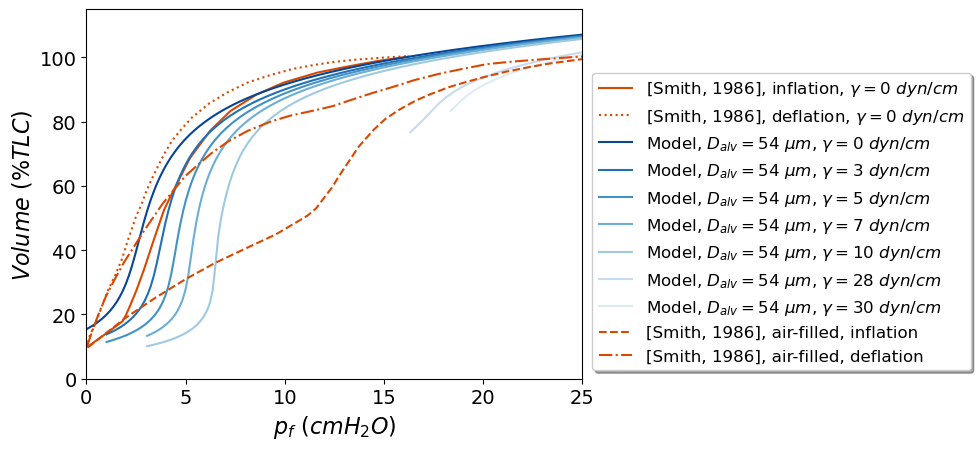

In [14]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(cm H_2O)$', fontsize=16)
plt.ylabel(r'$Volume~(\% TLC)$', fontsize=16)

plt.plot(p_smith_gamma_0_inf, v_smith_gamma_0_inf, '#D94801', label='[Smith, 1986], inflation, $\gamma = 0~dyn/cm$')
plt.plot(p_smith_gamma_0_def, v_smith_gamma_0_def, '#D94801', linestyle='dotted', label='[Smith, 1986], deflation, $\gamma = 0~dyn/cm$')

plt.plot(model_response_lst[0][1][0], model_response_lst[0][1][1], '#084594', label='Model, $D_{alv} = 54~\mu m$, $\gamma =$' +str(model_response_lst[0][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[1][1][0], model_response_lst[1][1][1], '#2171B5', label='Model, $D_{alv} = 54~\mu m$, $\gamma =$' +str(model_response_lst[1][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[2][1][0], model_response_lst[2][1][1], '#4292C6', label='Model, $D_{alv} = 54~\mu m$, $\gamma =$' +str(model_response_lst[2][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[3][1][0], model_response_lst[3][1][1], '#6BAED6', label='Model, $D_{alv} = 54~\mu m$, $\gamma =$' +str(model_response_lst[3][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[4][1][0], model_response_lst[4][1][1], '#9ECAE1', label='Model, $D_{alv} = 54~\mu m$, $\gamma =$' +str(model_response_lst[4][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[5][1][0], model_response_lst[5][1][1], '#C6DBEF', label='Model, $D_{alv} = 54~\mu m$, $\gamma =$' +str(model_response_lst[5][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[6][1][0], model_response_lst[6][1][1], '#DEEBF7', label='Model, $D_{alv} = 54~\mu m$, $\gamma =$' +str(model_response_lst[6][0])+ '$~dyn/cm$')

plt.plot(p_exp_gamma_inflation, v_exp_gamma_inflation, '#D94801', linestyle='dashed', label='[Smith, 1986], air-filled, inflation')
plt.plot(p_exp_gamma_deflation, v_exp_gamma_deflation, '#D94801', linestyle='dashdot', label='[Smith, 1986], air-filled, deflation')

plt.xlim(0, 25)
plt.ylim(0, 115)
plt.legend(loc = 'lower right', fontsize=12, bbox_to_anchor=(1.8, 0.), shadow=True)
plt.savefig('Figures/smith_intersect.pdf',bbox_inches='tight')


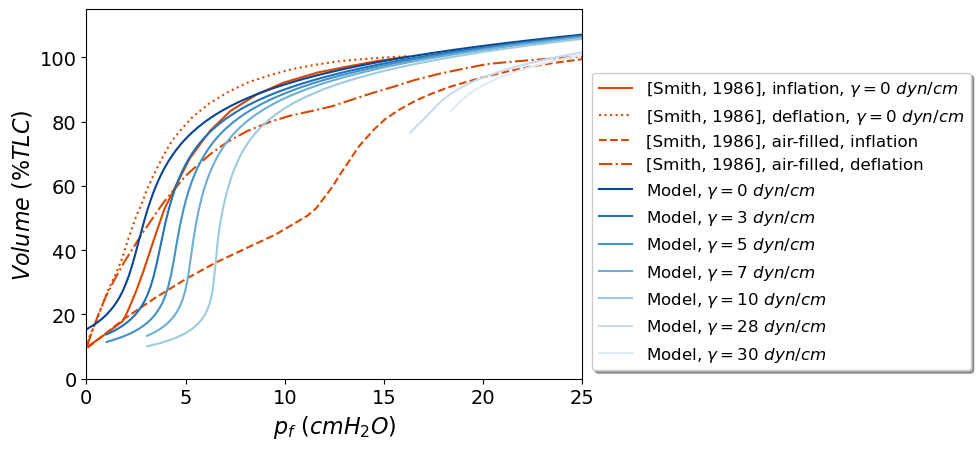

In [18]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(cm H_2O)$', fontsize=16)
plt.ylabel(r'$Volume~(\% TLC)$', fontsize=16)

plt.plot(p_smith_gamma_0_inf, v_smith_gamma_0_inf, '#D94801', label='[Smith, 1986], inflation, $\gamma = 0~dyn/cm$')
plt.plot(p_smith_gamma_0_def, v_smith_gamma_0_def, '#D94801', linestyle='dotted', label='[Smith, 1986], deflation, $\gamma = 0~dyn/cm$')

plt.plot(p_exp_gamma_inflation, v_exp_gamma_inflation, '#D94801', linestyle='dashed', label='[Smith, 1986], air-filled, inflation')
plt.plot(p_exp_gamma_deflation, v_exp_gamma_deflation, '#D94801', linestyle='dashdot', label='[Smith, 1986], air-filled, deflation')

plt.plot(model_response_lst[0][1][0], model_response_lst[0][1][1], '#084594', label='Model, $\gamma =$' +str(model_response_lst[0][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[1][1][0], model_response_lst[1][1][1], '#2171B5', label='Model, $\gamma =$' +str(model_response_lst[1][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[2][1][0], model_response_lst[2][1][1], '#4292C6', label='Model, $\gamma =$' +str(model_response_lst[2][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[3][1][0], model_response_lst[3][1][1], '#6BAED6', label='Model, $\gamma =$' +str(model_response_lst[3][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[4][1][0], model_response_lst[4][1][1], '#9ECAE1', label='Model, $\gamma =$' +str(model_response_lst[4][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[5][1][0], model_response_lst[5][1][1], '#C6DBEF', label='Model, $\gamma =$' +str(model_response_lst[5][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[6][1][0], model_response_lst[6][1][1], '#DEEBF7', label='Model, $\gamma =$' +str(model_response_lst[6][0])+ '$~dyn/cm$')


plt.xlim(0, 25)
plt.ylim(0, 115)
plt.legend(loc = 'lower right', fontsize=12, bbox_to_anchor=(1.8, 0.), shadow=True)
plt.savefig('Figures/smith_intersect.pdf',bbox_inches='tight')

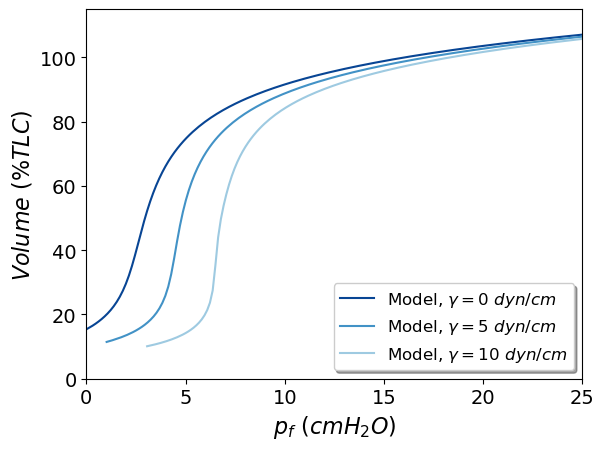

In [20]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$p_f~(cm H_2O)$', fontsize=16)
plt.ylabel(r'$Volume~(\% TLC)$', fontsize=16)

# plt.plot(p_smith_gamma_0_inf, v_smith_gamma_0_inf, '#D94801', label='[Smith, 1986], inflation, $\gamma = 0~dyn/cm$')
# plt.plot(p_smith_gamma_0_def, v_smith_gamma_0_def, '#D94801', linestyle='dotted', label='[Smith, 1986], deflation, $\gamma = 0~dyn/cm$')

# plt.plot(p_exp_gamma_inflation, v_exp_gamma_inflation, '#D94801', linestyle='dashed', label='[Smith, 1986], air-filled, inflation')
# plt.plot(p_exp_gamma_deflation, v_exp_gamma_deflation, '#D94801', linestyle='dashdot', label='[Smith, 1986], air-filled, deflation')

plt.plot(model_response_lst[0][1][0], model_response_lst[0][1][1], '#084594', label='Model, $\gamma =$' +str(model_response_lst[0][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[2][1][0], model_response_lst[2][1][1], '#4292C6', label='Model, $\gamma =$' +str(model_response_lst[2][0])+ '$~dyn/cm$')
plt.plot(model_response_lst[4][1][0], model_response_lst[4][1][1], '#9ECAE1', label='Model, $\gamma =$' +str(model_response_lst[4][0])+ '$~dyn/cm$')


plt.xlim(0, 25)
plt.ylim(0, 115)
plt.legend(loc = 'lower right', fontsize=12, bbox_to_anchor=(1., 0.), shadow=True)
plt.savefig('Figures/smith_intersect.pdf',bbox_inches='tight')

In [11]:
def intersect(lst, reference):
    p_lst = lst[0]
    v_lst = lst[1]
    S_lst = lst[2]
    pf_reference = reference[:, 0]
    vf_reference = reference[:, 1]
    first_line = LineString(numpy.column_stack((p_lst, v_lst)))
    second_line = LineString(numpy.column_stack((pf_reference, vf_reference)))
    intersection = first_line.intersection(second_line)
    gamma_S = intersection.x
    v = intersection.y

    first_line = LineString(numpy.column_stack((p_lst, S_lst)))
    second_line = LineString(numpy.column_stack((len(p_lst)*[gamma_S], S_lst)))
    intersection = first_line.intersection(second_line)
    return intersection.y, v

In [12]:
for i in range (1, len(model_response_lst)):
    model_response_lst[i].append(intersect(model_response_lst[i][1], exp_gamma_deflation))

gamma_lst_def = [sublist[0]/30 for sublist in model_response_lst[1:]]
S_intersect_def = [sublist[2][0] for sublist in model_response_lst[1:]]
gamma_lst_def = [0] + gamma_lst_def
S_intersect_def = [1] + S_intersect_def

for i in range (2, len(model_response_lst)):
    model_response_lst[i].append(intersect(model_response_lst[i][1], exp_gamma_inflation))

gamma_lst_inf = [sublist[0]/30 for sublist in model_response_lst[2:]]
S_intersect_inf = [sublist[3][0] for sublist in model_response_lst[2:]]
gamma_lst_inf = [0] + gamma_lst_inf
S_intersect_inf = [1] + S_intersect_inf

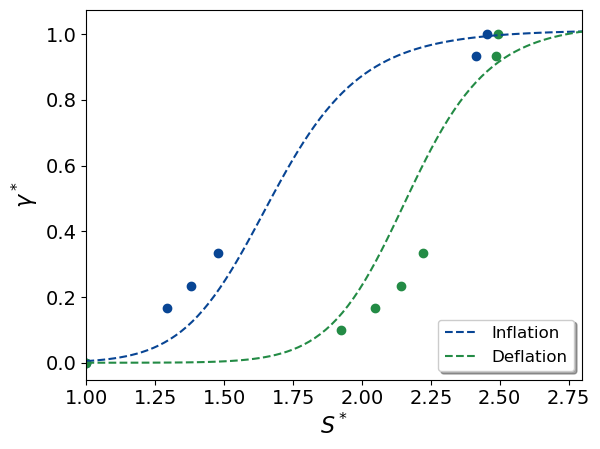

In [13]:
S_hat = sympy.symbols("S_hat")

gamma_S_iden_def =  1.030747711797792/(1 + (S_hat/2.1708848554526874)**(-14.828598856766776))
gamma_S_iden_inf = 1.0130287663205635/(1 + (S_hat/1.6742366271475184)**(-10.288589574038403))

lam_def = lambdify(S_hat, gamma_S_iden_def, modules=['numpy'])
lam_inf = lambdify(S_hat, gamma_S_iden_inf, modules=['numpy'])

S_hat_vals = linspace(1, 3, 100)
gamma_S_iden_vals_deflation = lam_def(S_hat_vals)
gamma_S_iden_vals_inflation = lam_inf(S_hat_vals)

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=12)
plt.xlabel(r'$S^*$', fontsize=16)
plt.ylabel(r'$\gamma^*$', fontsize=16)

plt.plot(S_intersect_inf, gamma_lst_inf, 'o', color='#084594')
plt.plot(S_intersect_def, gamma_lst_def, 'o', color='#238B45')
plt.plot(S_hat_vals, gamma_S_iden_vals_inflation, '#084594', linestyle = 'dashed', label='Inflation')
plt.plot(S_hat_vals, gamma_S_iden_vals_deflation, '#238B45', linestyle = 'dashed', label='Deflation')
plt.legend(loc = 'lower right', fontsize=12, shadow=True)
plt.xlim(1, 2.8)
plt.savefig('Figures/inf_def_fit.pdf',bbox_inches='tight')
# plt.ylim(0, 1)